In [57]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import LSTM , Embedding , Dense , Dropout 
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential , regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from nltk import word_tokenize, sent_tokenize
from sklearn.metrics import recall_score , precision_score , accuracy_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import  PorterStemmer

In [4]:
# Read the data
df = pd.read_csv("DataSet/Twitter_Data.csv")
df.sample(5)

,clean_text,category
37339,congratulations tejasvi surya youngest candida...,1.0
86668,none pertains modijis period under modi scanne...,1.0
51229,modi informing the world about our space capab...,-1.0
99611,all the benami companies closed modi will open...,-1.0
22564,ban words for 2019 election\nmandir\nmasjid\nh...,0.0


In [5]:
%pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
df.shape

(162980, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [8]:
# Checking for null values
print(df.isnull().sum())

# Drop null rows
df.dropna(axis=0 , inplace=True)

# after removing null values
print(df.isnull().sum())

clean_text    4
category      7
dtype: int64
clean_text    0
category      0
dtype: int64


In [9]:
# Check for dunplicates
df.duplicated().sum()

0

<Axes: ylabel='count'>

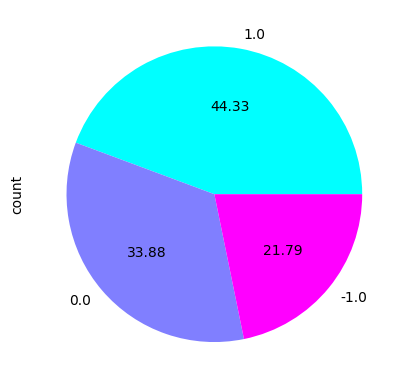

In [10]:
# EDA
df['category'].value_counts().plot(kind= "pie" , cmap = "cool" ,autopct = "%.2f" )

In [11]:
# Adding new attributes for more effective EDA
df['charcount'] = df['clean_text'].apply(len)
df['wordcount'] = df['clean_text'].apply(lambda x: len(word_tokenize(x)))
df['sencount'] = df['clean_text'].apply(lambda x: len(sent_tokenize(x)))

In [12]:
df.sample(5)

,clean_text,category,charcount,wordcount,sencount
79549,keep licking the eggs ashraf ghani and modi,0.0,43,8,1
153715,playing double standard politics dangerous gam...,-1.0,155,19,1
13592,yes will use the bank accounts created modi go...,1.0,177,30,1
109396,insightful into the psyche modi shows how trea...,0.0,129,21,1
37629,honour asks fight against sonia gandhi says ex...,1.0,72,11,1


<Axes: >

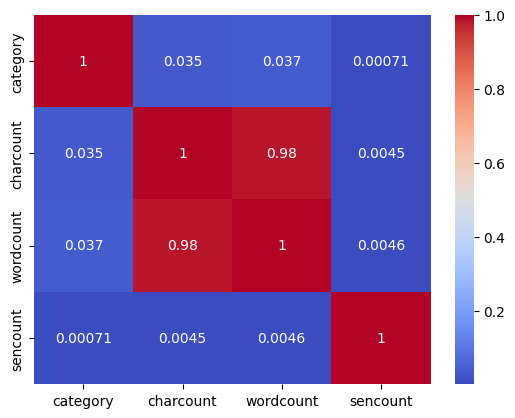

In [13]:
# Coorealtion matrix to find correction between attributes
corr_matrix = df.select_dtypes("number").corr()
sns.heatmap(corr_matrix , annot= True , cmap= "coolwarm")

# Result --> no Significance corr

In [14]:
# Genrate Word Clouds
wc_pos = WordCloud(width = 600 , height = 600 , background_color = 'black' , min_font_size = 10 )
wc_neg = WordCloud(width = 600 , height = 600 , background_color = 'black' , min_font_size = 10 )
wc_neu = WordCloud(width = 600 , height = 600 , background_color = 'black' , min_font_size = 10 )

positve_wc = wc_pos.generate(df[df['category'] == 1]['clean_text'].str.cat(sep = " "))
negative_wc = wc_neg.generate(df[df['category'] == -1]['clean_text'].str.cat(sep = " "))
neutral_wc = wc_neu.generate(df[df['category'] == 0]['clean_text'].str.cat(sep = " "))

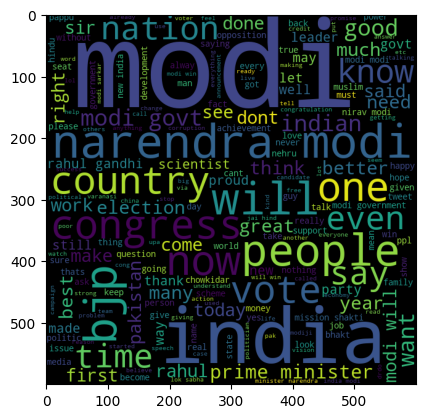

In [15]:
# Postive sentiment wordcloud
plt.imshow(positve_wc)

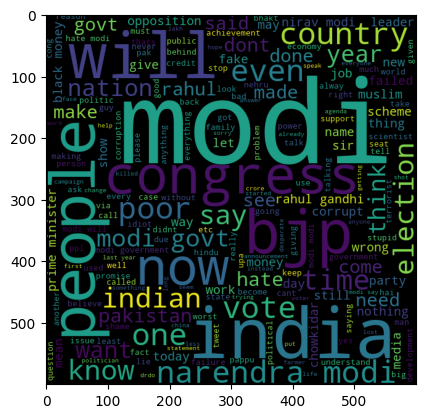

In [16]:
# Negaive sentiment wordcloud
plt.imshow(negative_wc)

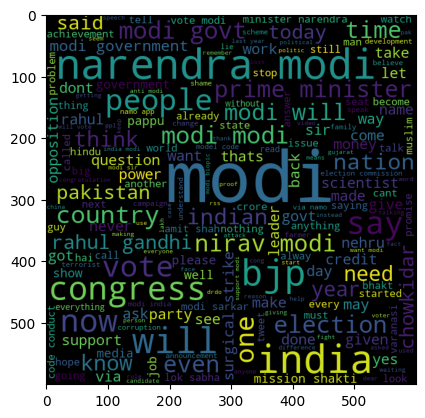

In [17]:
# neural sentiment wordcloud
plt.imshow(neutral_wc)

In [18]:
# Data preprocessing

df['clean_text'] = df['clean_text'].str.lower()

In [19]:
# Remove puntuation from texts
import string
exclude = string.punctuation 
def remove_pun(text):
    return text.translate(str.maketrans("" , '' , exclude))

df['clean_text'] = df['clean_text'].apply(remove_pun)

df['clean_text'].iloc[:3]

0    when modi promised “minimum government maximum...
1    talk all the nonsense and continue all the dra...
2    what did just say vote for modi  welcome bjp t...
Name: clean_text, dtype: object

In [20]:
# Convert each word into it's root word 

ps = PorterStemmer()

def stem_word(text):
    return " ".join([ps.stem(word) for word in text.split()])

df['clean_text'] = df['clean_text'].apply(stem_word)


In [62]:
# Train Test Split
X = df['clean_text']
y = df['category']

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size= .2 , random_state= 42)

In [63]:
# Word Embedding layer
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

# Find vocab length
vocab_len = len(word_tokenizer.word_index) + 1

# Pad sequences
max_len = 150
X_train = pad_sequences(X_train, padding="post", maxlen=max_len)
X_test = pad_sequences(X_test, padding="post", maxlen=max_len)

# One-hot encode labels
num_classes = 3  # Assuming there are 3 classes: 0, 1, -1
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Define the model
model = Sequential([
    Embedding(input_dim=vocab_len, output_dim=200, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(128),
    Dense(64, activation='relu', 
          kernel_regularizer=regularizers.l2(0.01), 
          activity_regularizer=regularizers.l1(0.01)),
    Dense(num_classes, activation='softmax')  # number of classes (sentiment categories)
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
print(model.summary())


c:\Users\singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 150, 200)       │    16,266,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 150, 128)       │       168,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,575,283 (63.23 MB)

 Trainable params: 16,575,283 (63.23 MB)

 Non-trainable params: 0 (0.00 B)

None


In [50]:

# Create early stopping object
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

# Train the model with the one-hot encoded labels
history = model.fit(X_train, y_train_one_hot, epochs= 5, batch_size= 128, validation_data=(X_test, y_test_one_hot), callbacks=[early_stopping])

Epoch 1/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 606s 595ms/step - accuracy: 0.4441 - loss: 1.0589 - val_accuracy: 0.4410 - val_loss: 1.0607
Epoch 2/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 610s 598ms/step - accuracy: 0.4449 - loss: 1.0588 - val_accuracy: 0.4410 - val_loss: 1.0606
Epoch 3/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 615s 603ms/step - accuracy: 0.4432 - loss: 1.0593 - val_accuracy: 0.4410 - val_loss: 1.0607
Epoch 4/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 595s 584ms/step - accuracy: 0.4444 - loss: 1.0592 - val_accuracy: 0.4410 - val_loss: 1.0606
Epoch 5/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 590s 579ms/step - accuracy: 0.4434 - loss: 1.0591 - val_accuracy: 0.4410 - val_loss: 1.0606
Epoch 5: early stopping


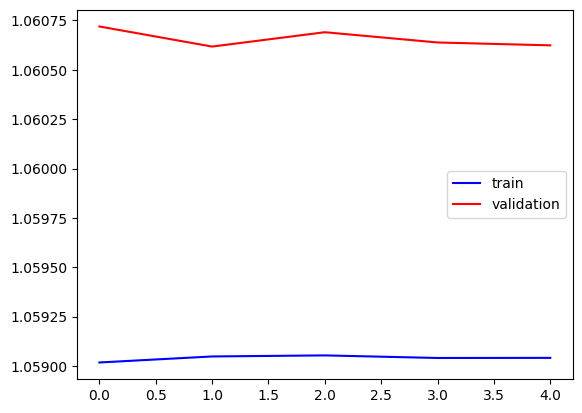

In [52]:
# Cheking for overfitting ( without BatchNormalization and dropout layer )
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , color = "blue" , label = "train")
plt.plot(history.history['val_loss'] , color = "red" , label = "validation")
plt.legend()
plt.show()

In [60]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the model
score = model.evaluate(X_test, y_test_one_hot, verbose=1)

# Predict the labels
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_test back to class labels
y_test_argmax = np.argmax(y_test_one_hot, axis=1)

# Calculate precision, recall, and F1 score
print('Precision:', precision_score(y_test_argmax, y_pred, average='weighted'))
print('Recall:', recall_score(y_test_argmax, y_pred, average='weighted'))
print('F1 Score:', f1_score(y_test_argmax, y_pred, average='weighted'))


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.4381 - loss: 1.0620
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step
Precision: 0.1945093059939872
Recall: 0.4410320917960361
F1 Score: 0.2699583265374191


c:\Users\singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [56]:
# Example
sentence = ["The movie was very touching and heart whelming"]

# convert to a sequence
sequences = word_tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, padding='post', maxlen=max_len)

# predict using the Trained model
prediction = model.predict(padded)

print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
[[0.33948854 0.44252238 0.21798913]]
